# Energy and time Predictions for the kinarm reaching model. 

In the following code we create a kinarm model and perform optimizations to find the trajectories and movement times for reaches of different distances, and different valuations of time.

if you set 'theGeneratePlots=1', you will get 6 plots per optimization.


In [1]:
#%% Loop across distances and valuations to generate double-pendulum distance/time predictions. 
import ReachingModels as reaching
import numpy as np
import matplotlib.pyplot as plt
import colour as clr
import plotpresentlib as pp
from matplotlib.figure import Figure

%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(0,'parameterFiles')

# model that has equations to compute endpoint jacobians, equations of motion, and energy. 
sim = reaching.KinarmGlobal()
#sim = reaching.PointMass()

# starting x and y
x = 0.0
ys = 0.20
xystart = np.array([x,ys])

loopValuation = [.25,.5,.75,1,3,5,7,15,20,70,100,150,200,300] # for fit
loopValuation = [1,10,100]
# loopValuation = [20]
loopdist = np.array([.005, .01, .025, .05, .075, .1, .2, .25, .3, .35, .4, .45, .5])

color1 = clr.Color("#e0f3db")
distcolors = list(color1.range_to(clr.Color("#084081"),len(loopValuation)))

### storing the main results in matrices: durations, speeds, costs, rewards, solved
M = len(loopValuation)
N = len(loopdist)
duration      = np.zeros([M, N])
J             = np.zeros([M, N])
costFR        = np.zeros([M, N])
costWork      = np.zeros([M, N])
costTime      = np.zeros([M, N])
peakhandspeed = np.zeros([M, N])
solved        = np.zeros([M, N])
distances     = np.zeros([M, N])
timeValuation = np.zeros([M, N])
nDist         = 0 #counters
mVal          = 0 #counters

### store returned trajectories
# store trajectories
trajAll       = list() #ultimately the 2D matrix storage
trajFixedDist = list() # fixedDist get reset each inner loop
# store returned Opti variables
optiAll       = list() # ultimately the 2D matrix storage 
optiFixedDist = list() # fixedDist get reset each inner loop

### setup the optimization. 
optiPrev = sim.movementTimeOptSetup(
  theTimeValuation  = 1.0,
  theN              = 60,   #2022-10: 20 and 40 both work flawlessly. this is after removing accel = 0 constraint. 
  theFRCoef         = 0.085)

### solve the opt once, we can then always use optiOrig as initial guess. 
trajOrig, optiOrig = sim.updateGuessAndSolve(
  optiPrev, 
  xystart, 
  xystart + np.array([x,.10]),
  theDurationGuess    = 1,
  theTimeValuation    = 1,
  theGeneratePlots    = 0)
dGuess = trajOrig.duration

for i in loopdist:  
  for j in loopValuation:
    trajResult, optiReturn = sim.updateGuessAndSolve(
      optiPrev, 
      xystart, 
      xystart + np.array([x,i]), 
      theDurationGuess  = dGuess,
      theTimeValuation    = j,
      theGeneratePlots    = 0)
    
    # if we found a solution:
    if trajResult.solved:
      # unpack the results
      duration[mVal,nDist]      = trajResult.duration
      J[mVal,nDist]             = trajResult.costJ
      costFR[mVal,nDist]        = trajResult.costFR
      costWork[mVal,nDist]      = trajResult.costWork
      costTime[mVal,nDist]      = trajResult.costTime
      peakhandspeed[mVal,nDist] = trajResult.peakhandspeed
      solved[mVal,nDist]        = trajResult.solved
      distances[mVal,nDist]     = i
      timeValuation[mVal,nDist] = j
      # update the optiPrev, only if solved == true.
      #optiPrev  = optiReturn
      dGuess    = trajResult.duration
    
    #increment inner
    mVal += 1
    trajFixedDist.append(trajResult)
    optiFixedDist.append(optiReturn)

  
  #reset col counter; increase nDist
  mVal = 0
  nDist += 1
  trajAll.append(trajFixedDist)
  optiAll.append(optiFixedDist)
  
  optiPrev = optiOrig
  trajFixedDist = []
  optiFixedDist = []
# %%



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3446
Number of nonzeros in inequality constraint Jacobian.:     1343
Number of nonzeros in Lagrangian Hessian.............:     1818

Total number of variables............................:     1099
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [3]:
saveDict = {
  "tSol":duration,
  "maxspeed":peakhandspeed,
  "dists":distances,
  "timeValuation":timeValuation}
import scipy
scipy.io.savemat('simulationResults/results.mat', saveDict)


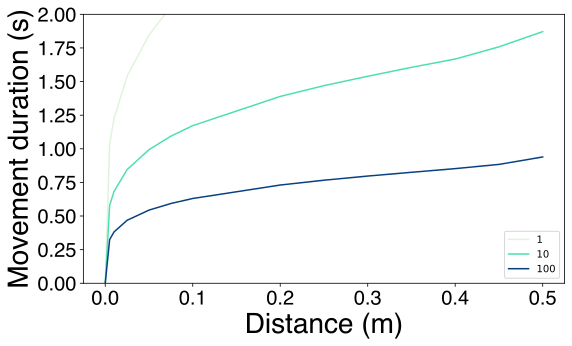

In [2]:
#%% Figure 1: duration / distance 

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[v,:]
  y = y.T
  ytemp = np.concatenate(([0],y))
  
  xtemp = np.concatenate(([0],xtemp))
  inds = ytemp !=0
  plt.plot(xtemp,ytemp,label=loopValuation[v],color = distcolors[v].get_hex())

plt.legend()
# %%
plt.xlabel("Distance (m)")
plt.ylabel("Movement duration (s)")
ax.set_ylim(0,2)
pp.figurefyTalk()


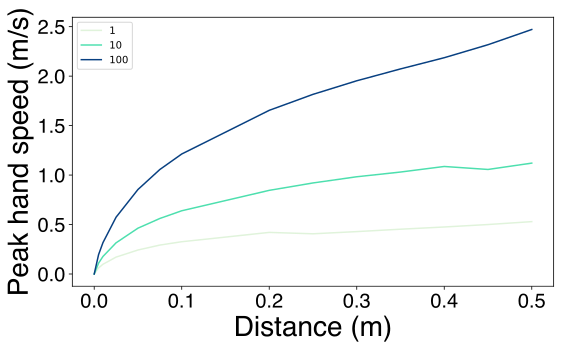

In [3]:
#%% Figure 2: distance peak speed / distance
f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v].get_hex())
  plt.xlabel("Distance (m)")
  plt.ylabel("Peak hand speed (m/s)")
  plt.legend()

pp.figurefyTalk()
# %%

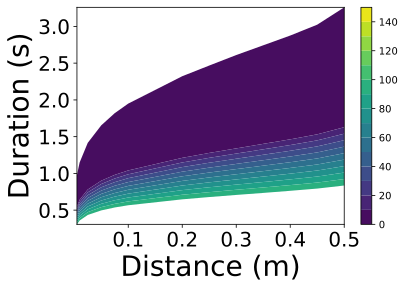

In [6]:
from matplotlib import cm
cColor = cm.get_cmap('viridis')#viridis

plt.contourf(distances,duration, timeValuation,levels=np.linspace(0,150,16),cmap =cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (m)',fontsize = 28)
plt.ylabel('Duration (s)',fontsize = 28)
plt.colorbar()

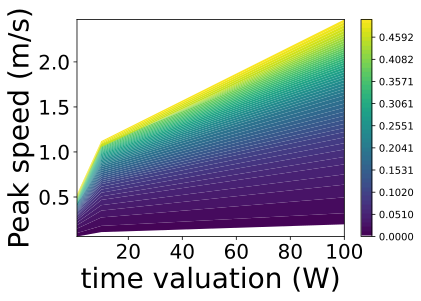

In [4]:
# plt.contourf(distances,peakhandspeed, timeValuation,levels=np.linspace(0,150,16)) #,cmap=jet.reversed() 
plt.contourf(timeValuation,peakhandspeed, distances,levels=np.linspace(0,.5,50)) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('time valuation (W)',fontsize = 28)
plt.ylabel('Peak speed (m/s)',fontsize = 28)
fig = plt.gcf()

plt.colorbar()
plt.savefig("pred_distSpeed.eps")

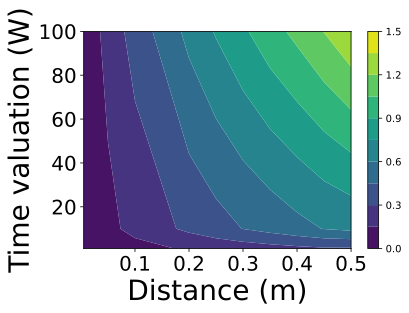

In [8]:

plt.contourf(distances,timeValuation, peakhandspeed,levels=np.linspace(0,1.5,11),cmap=cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (m)',fontsize = 28)
plt.ylabel('Time valuation (W)',fontsize = 28)
plt.colorbar()


IndexError: list index out of range

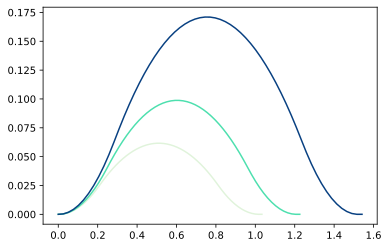

In [5]:
#%% Figure 3: 3 valuations, hand speed vs time
def plotBells(trajs:list,theVal):
  for i in range(0,len(trajs)):
    tempDist = trajs[i]
    tempStruct = tempDist[theVal]
    plt.plot(tempStruct.time,tempStruct.handspeed,distcolors[i].get_hex())

f,ax = plt.subplots()
plotBells(trajAll,0)
plotBells(trajAll,1)
plotBells(trajAll,2)

plt.ylabel("Hand speed [m/s]")
plt.xlabel("Time [s]")
pp.figurefyTalk()

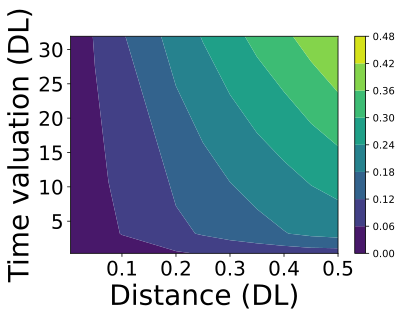

In [11]:
import DimensionalAnalysis as da
plt.contourf(distances*da.distanceNorm(),timeValuation*da.timeNorm(), peakhandspeed*da.velocityNorm(), cmap=cColor) #,cmap=jet.reversed() 
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Distance (DL)',fontsize = 28)
plt.ylabel('Time valuation (DL)',fontsize = 28)
plt.colorbar()


# Fit powerlaw relations. 
$$ max(\dot{x}(t)) \propto distance^{1/4}$$
$$ t_{end} \propto distance^{3/4}$$

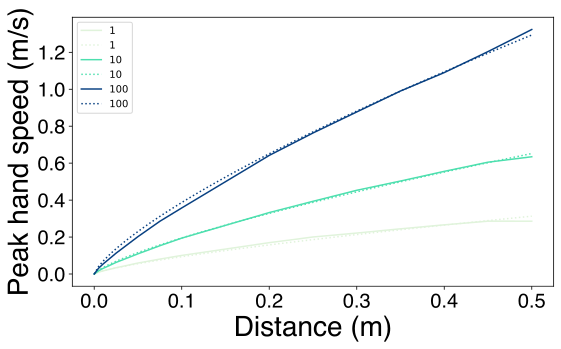

In [48]:
# fit a few of the speed-distance and duration-distance to power-law relations:
# ps ~        distance^3/4
# duration ~  distance^1/4
powerPS = 3/4
powerDur = 1/4

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):
#v = 0
  xtemp = loopdist.copy()
  y = peakhandspeed.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  mat  = np.array([xtemp**(powerPS)]).T
  coef = np.linalg.pinv(mat) @ np.array([ytemp]).T
  xfit = np.linspace(0,max(xtemp),100)
  yfit = coef[0] * xfit**(powerPS)
  #yfit = yfit[0,:]
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v].get_hex())
  plt.plot(xfit,yfit, label=loopValuation[v],color = distcolors[v].get_hex(),linestyle='dotted')
  plt.xlabel("Distance (m)")
  plt.ylabel("Peak hand speed (m/s)")
  
  plt.legend()

pp.figurefyTalk()


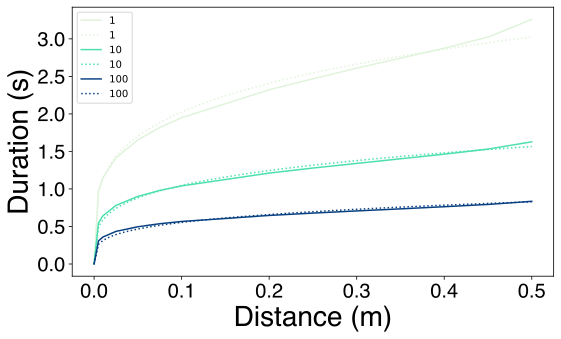

In [51]:

powerDur = 1/4

f,ax = plt.subplots()
for v in range(0,len(loopValuation)):

  xtemp = loopdist.copy()
  y = duration.copy()
  y = y[v,:]
  ytemp = np.concatenate(([0],y))

  xtemp = np.concatenate(([0],xtemp))
  mat  = np.array([xtemp**(powerDur)]).T
  coef = np.linalg.pinv(mat) @ np.array([ytemp]).T
  xfit = np.linspace(0,max(xtemp),100)
  yfit = coef[0] * xfit**(powerDur)
  #yfit = yfit[0,:]
  plt.plot(xtemp,ytemp, label=loopValuation[v],color = distcolors[v].get_hex())
  plt.plot(xfit,yfit, label=loopValuation[v],color = distcolors[v].get_hex(),linestyle='dotted')
  plt.xlabel("Distance (m)")
  plt.ylabel("Duration (s)")
  
  plt.legend()

pp.figurefyTalk()

In [46]:
yfit.shape

(100,)

In [15]:
mat = 

(1, 1, 14)